# Conditional Generative Adversarial Networks (cGAN)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def make_discriminator_model(input_shape=(28, 28, 1), n_classes=10):
  class_input = tf.keras.Input(shape=(1,))
  label_input = tf.keras.layers.Embedding(n_classes, 50)(class_input)

  n_nodes = input_shape[0] * input_shape[1]
  label_input = tf.keras.layers.Dense(n_nodes)(label_input)
  label_input = tf.keras.layers.Reshape(input_shape)(label_input)

  image_input = tf.keras.Input(shape=input_shape)
  merge = tf.keras.layers.Concatenate()([image_input, label_input])

  fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
  fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)

  fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)

  fe = tf.keras.layers.Flatten()(fe)
  fe = tf.keras.layers.Dropout(0.4)(fe)

  out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(fe)

  model = tf.keras.Model([image_input, class_input], out_layer)

  opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [3]:
make_discriminator_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 784)       39984       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                              

In [4]:
def make_generator_model(latent_dim=100, n_classes=10):
  in_label = tf.keras.Input(shape=(1,))
  label_input = tf.keras.layers.Embedding(n_classes, 50)(in_label)

  n_nodes = 7 * 7
  label_input = tf.keras.layers.Dense(n_nodes)(label_input)
  label_input = tf.keras.layers.Reshape((7, 7, 1))(label_input)

  latent_input = tf.keras.Input(shape=(latent_dim,))

  n_nodes = 128 * 7 * 7
  gen = tf.keras.layers.Dense(n_nodes)(latent_input)
  gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
  gen = tf.keras.layers.Reshape((7, 7, 128))(gen)

  merge = tf.keras.layers.Concatenate()([gen, label_input])

  gen = tf.keras.layers.Conv2DTranspose(128, (4,4), 
                                        strides=(2,2), padding='same')(merge)
  gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

  gen = tf.keras.layers.Conv2DTranspose(128, (4,4), 
                                        strides=(2,2), padding='same')(gen)
  gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

  out_layer = tf.keras.layers.Conv2D(1, (7,7), 
                                     activation='tanh', padding='same')(gen)

  model = tf.keras.Model([latent_input, in_label], out_layer)
  return model

In [5]:
def make_gan_model(g_model, d_model):
  d_model.trainable = False

  g_latent, g_label = g_model.input
  g_output = g_model.output

  gan_output = d_model([g_output, g_label])

  model = tf.keras.Model([g_latent, g_label], gan_output)

  opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [6]:
make_gan_model(make_generator_model(), make_discriminator_model()).summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 6272)         633472      ['input_4[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                            

In [7]:
def generate_real_samples(dataset, batch_size):
  indx = tf.random.uniform((batch_size,), 
                           maxval=dataset[0].shape[0], dtype=tf.int32).numpy()
  X = dataset[0][indx]
  L = dataset[1][indx]
  y = tf.ones((batch_size, 1))
  return [X,L], y

In [8]:
def generate_fake_samples(g_model, latent_dim, batch_size, n_classes=10):
  samples = tf.random.normal((batch_size, latent_dim))
  labels = tf.random.uniform((batch_size,), maxval=n_classes, dtype=tf.int32)
  X = g_model.predict([samples, labels])
  y = tf.zeros((batch_size, 1))
  return [X,labels], y

In [9]:
def plot_classes(g_model, latent_dim, n=10):
  samples = tf.random.normal((10*n, latent_dim))
  labels = tf.range(0, 10)
  labels = tf.repeat(labels, repeats=[10 for _ in range(10)])
  X = g_model.predict([samples, labels])
  images = (X + 1) / 2.0

  fig = plt.figure(figsize=(10, 10))
  for i in range(10 * n):
    plt.subplot(10, n, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray_r')
    plt.axis('off')
  plt.show()

In [10]:
def train(gan_model, g_model, d_model, dataset, 
          latent_dim=100, batch_size=128, n_epochs=100):
  half_batch_size = batch_size // 2
  n_batches = dataset[0].shape[0] // batch_size
  for i in range(n_epochs):
    for j in range(n_batches):
      [X_real, labels_real], y_real = generate_real_samples(dataset, 
                                                            half_batch_size)
      [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim,
                                                            half_batch_size)
      X = tf.concat((X_real, X_fake), axis=0)
      labels = tf.concat((labels_real, labels_fake), axis=0)
      y = tf.concat((y_real, y_fake), axis=0)

      d_loss = d_model.train_on_batch([X, labels], y)

      X_gan = tf.random.normal((batch_size, latent_dim))
      gan_labels = tf.random.uniform((batch_size,), maxval=10, 
                                 dtype=tf.int32)
      y_gan = tf.ones((batch_size, 1))

      g_loss = gan_model.train_on_batch([X_gan, gan_labels], y_gan)

    if (i+1)%10 == 0:
      print(d_loss, g_loss)
      plot_classes(g_model, latent_dim)

In [11]:
def normalize_images(images):
  X = tf.expand_dims(images, -1).numpy()
  X = X.astype('float32')
  X = (X - 127.5) / 127.5
  return X

In [12]:
from keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

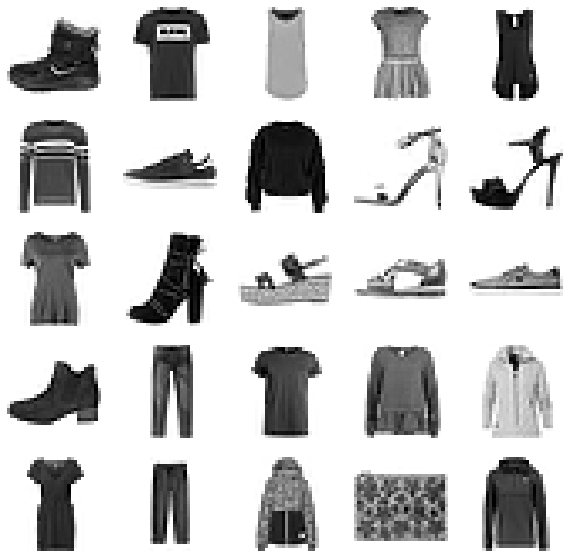

Shape: (28, 28)


In [13]:
fig = plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, 1+i)
  plt.axis('off')
  plt.imshow(train_images[i], cmap='gray_r')
plt.show()
print("Shape: {}".format(train_images[0].shape))

In [14]:
data = (normalize_images(train_images), train_labels)

[0.6439924240112305, 0.625] 0.7771395444869995


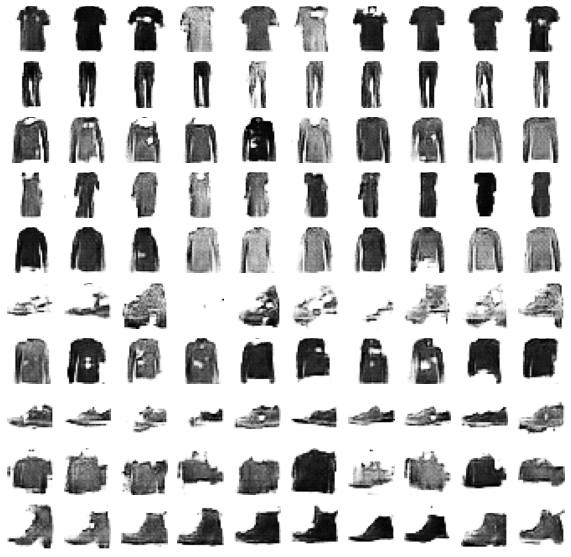

[0.6669017672538757, 0.5859375] 0.9207823276519775


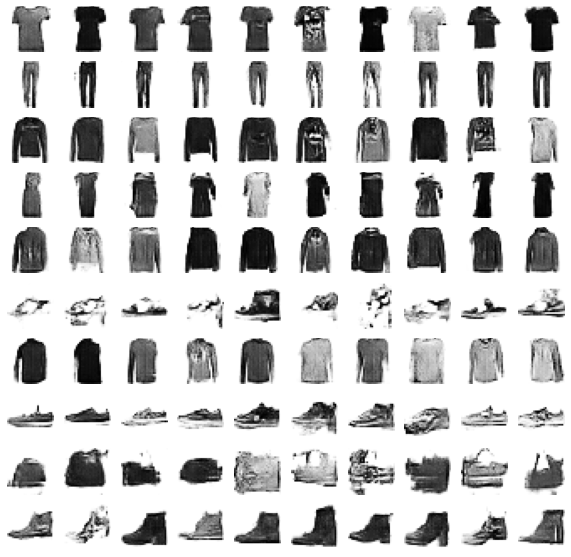

[0.6915203332901001, 0.609375] 0.8525887131690979


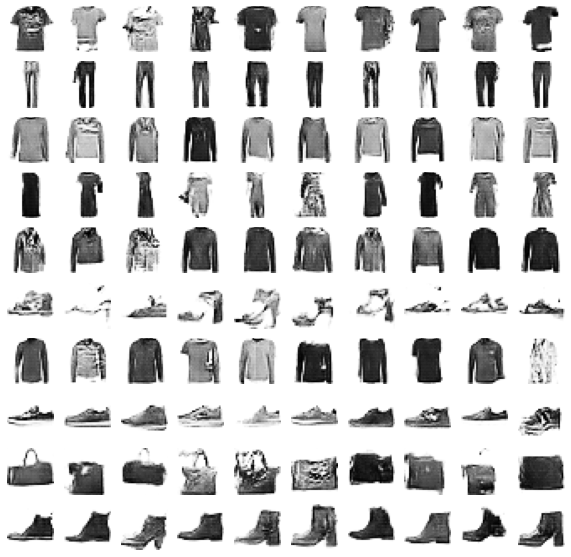

[0.6718783378601074, 0.6171875] 0.7353734374046326


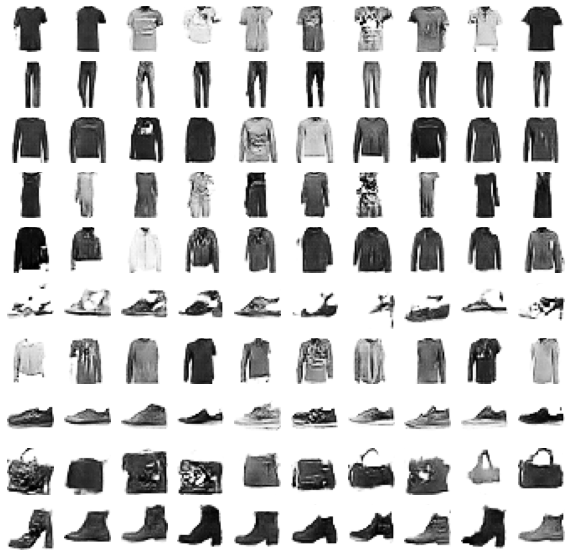

[0.7006694674491882, 0.5546875] 0.7498834133148193


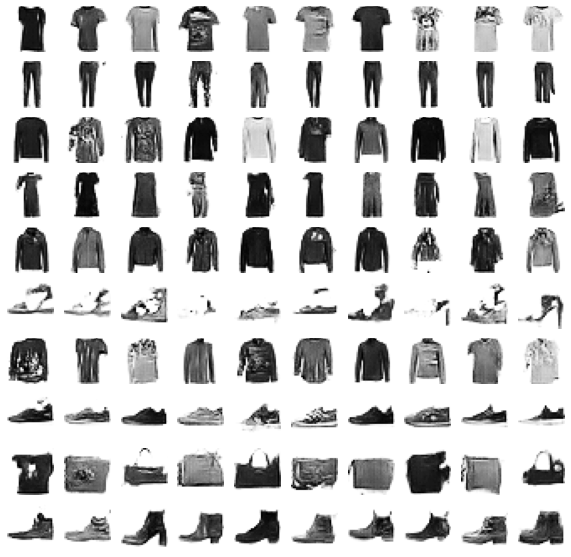

[0.6792595386505127, 0.5234375] 0.7822626233100891


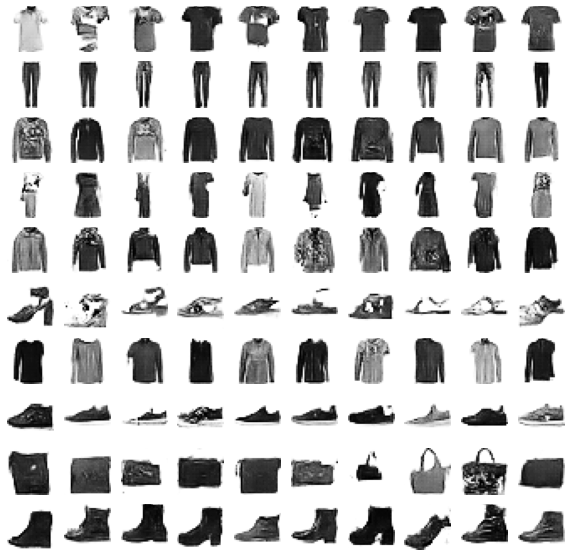

[0.6623739004135132, 0.5703125] 0.7581104040145874


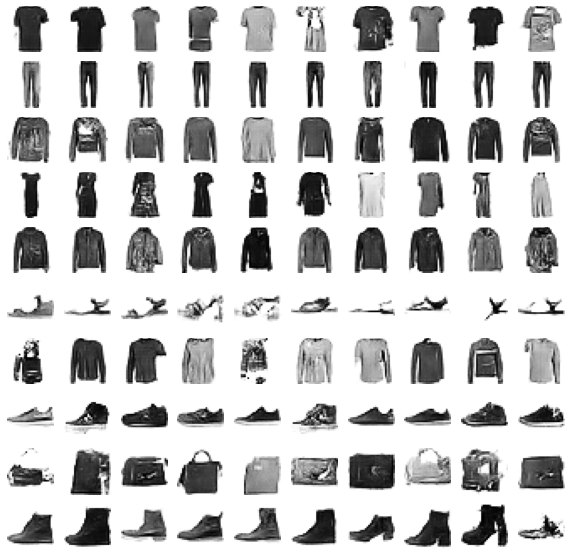

[0.6581840515136719, 0.5859375] 0.7872748374938965


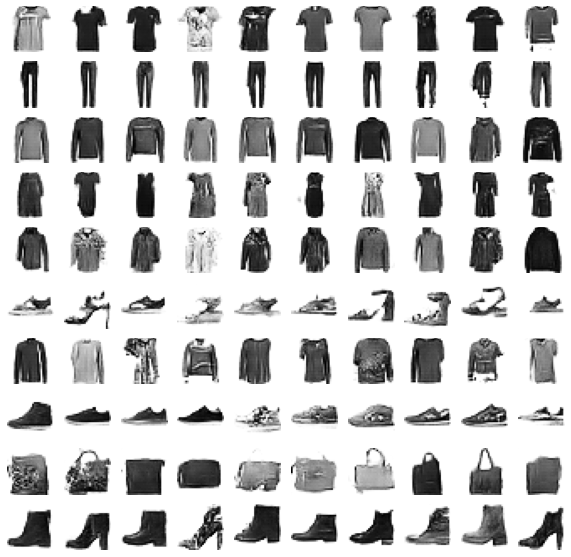

[0.6549907922744751, 0.6171875] 0.8043972253799438


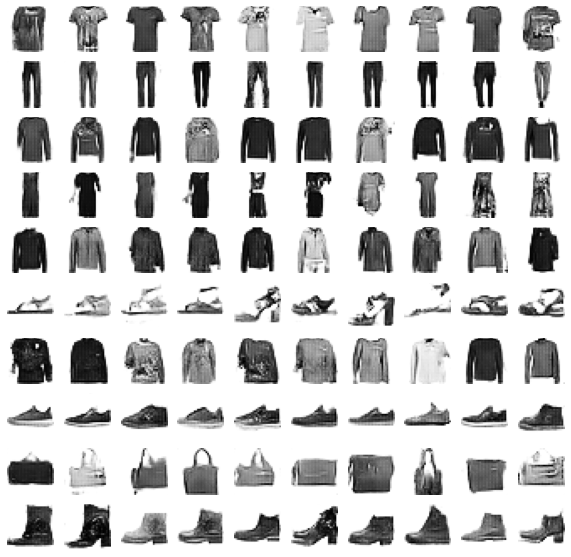

[0.6737982034683228, 0.6015625] 0.8893283009529114


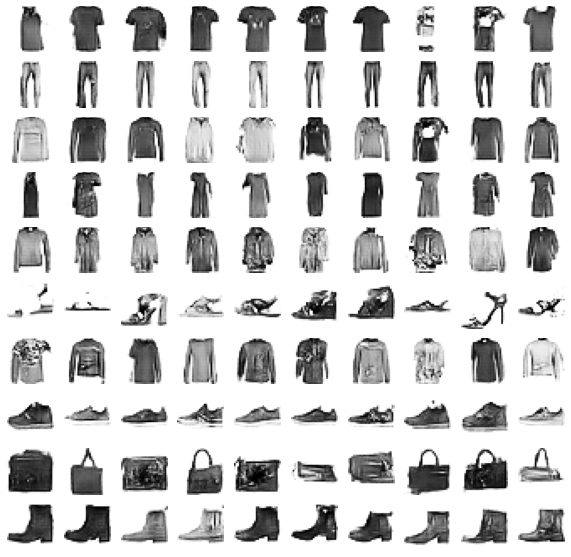

In [15]:
d_model = make_discriminator_model()
g_model = make_generator_model()

gan_model = make_gan_model(g_model, d_model)

train(gan_model, g_model, d_model, data)